# **尚未使用**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **資料預處理**

In [ ]:
from zipfile import ZipFile
path = "/content/drive/MyDrive/ttgroup/0_9000/0519_crop_hd_save_pics.zip"
f = ZipFile(path)
# f.extractall() 小括號是直接解壓縮在同一層
f.extractall()

In [ ]:
# 製作igm_name的list
import glob
import pandas as pd
import numpy as np

# sorted() : 排序所有可跌代對象
# split() : 分割()
fn_dic = {"img_name":[]}
paths = sorted(glob.glob("0519_crop_hd_save_pics/*"))
for path in paths:
  fn = path.split("/")[-1].split(".")[0]
  fn_dic["img_name"].append(fn)
fn_dic_df = pd.DataFrame(fn_dic)
fn_dic_df

,img_name
0,0004
1,0044
2,0070
3,0089
4,0095
...,...
580,8868
581,8872
582,8877
583,8903


In [ ]:
# img_combine_arr 訓練資料DataFarme (x_train, x_test)
from PIL import Image
fn_list = fn_dic["img_name"]

# # RGB寫法
img_arr_list = []
for fn in fn_list:
  img = Image.open("/content/0519_crop_hd_save_pics/" + fn + ".jpg").convert("RGB")
  img = img.resize((256, 256))
  globals()["img_"+ fn] = img
  globals()["img_"+ fn + "_arr"] = np.array(globals()["img_"+fn])
  img_arr_list.append(globals()["img_"+ fn + "_arr"])
  img.close()
# img_arr_list = ()
img_combine_arr = np.array(img_arr_list)
img_combine_arr.shape
# img_combine_arr[0]

(585, 256, 256, 3)

In [ ]:
# ans_df  驗證資料DataFrame (y_train, y_test)
base = "/content/drive/MyDrive/ttgroup/0_9000/0519_wrong_total_sit_value_combinefoot_0_9000.csv"
csv = pd.read_csv(base, sep=",")
ans_df = pd.DataFrame(csv)
# ans_df = ans_df.drop(["img_name"], axis=1)
# ans_arr = np.array(ans_df)
# # ans_df
# ans_sho_df = pd.DataFrame(ans_df["shoulder"])
# ans_sho_df
# ans_imn_sho_df = ans_df.drop(["head","foot"], axis=1)
# ans_imn_sho_df
ans_imn_hd_df = ans_df.drop(["shoulder","foot"], axis=1)
ans_imn_hd_df

,img_name,head
0,4,1
1,44,1
2,70,1
3,89,1
4,95,1
...,...,...
580,8868,1
581,8872,0
582,8877,1
583,8903,0


In [ ]:
# 切割資料 x_train, x_test, y_train, y_test
# 將image_name跟y_train, y_test一起切割
from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(img_combine_arr,
                             np.array(ans_imn_hd_df),
                             test_size=0.1)

In [ ]:
# 將image_name 的y_train, y_test 拿出來
y_train_imn_df = pd.DataFrame(y_train)[0]
y_test_imn_df = pd.DataFrame(y_test)[0]

y_train_df = pd.DataFrame(y_train)[1]
y_test_df = pd.DataFrame(y_test)[1]
print(y_train_df)
# print(len(y_test_df))
y_train = np.array(y_train_df).reshape(len(y_train_df),1)
y_test = np.array(y_test_df).reshape(len(y_test_df),1)


0      1
1      1
2      1
3      1
4      0
      ..
521    1
522    0
523    1
524    1
525    1
Name: 1, Length: 526, dtype: int64


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(526, 256, 256, 3)
(526, 1)
(59, 256, 256, 3)
(59, 1)


88
[1]


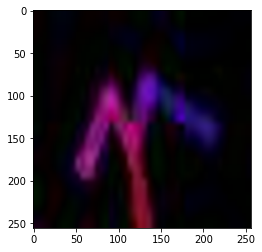

In [ ]:
# 顯示圖片和標籤
import random
import matplotlib.pyplot as plt
idx = random.randint(0, 260)
print(idx)
print(y_train[idx])
plt.imshow(x_train[idx])

# **模型建置**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
layers = [
    Conv2D(32, 3, padding="same", activation="relu", input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(512, 3, padding="same", activation="relu"),
    GlobalAveragePooling2D(),
    Dense(1, activation="sigmoid")
]
model = Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       2

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
model.compile(loss=BinaryCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [ ]:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
   EarlyStopping(patience=5, restore_best_weights=True),
   ModelCheckpoint("cnn.h5", save_best_only=True) 
]

model.fit(x_train_norm,
     y_train,
     batch_size=20,
     epochs=50,
     validation_split=0.1,
     verbose=2,
     callbacks=callbacks)

Epoch 1/50
24/24 - 37s - loss: 0.5832 - accuracy: 0.7315 - val_loss: 0.4519 - val_accuracy: 0.8302
Epoch 2/50
24/24 - 1s - loss: 0.5866 - accuracy: 0.7442 - val_loss: 0.4446 - val_accuracy: 0.8302
Epoch 3/50
24/24 - 1s - loss: 0.5628 - accuracy: 0.7442 - val_loss: 0.4312 - val_accuracy: 0.8302
Epoch 4/50
24/24 - 1s - loss: 0.5796 - accuracy: 0.7442 - val_loss: 0.4677 - val_accuracy: 0.8302
Epoch 5/50
24/24 - 1s - loss: 0.5523 - accuracy: 0.7442 - val_loss: 0.4275 - val_accuracy: 0.8302
Epoch 6/50
24/24 - 1s - loss: 0.5488 - accuracy: 0.7442 - val_loss: 0.4914 - val_accuracy: 0.8302
Epoch 7/50
24/24 - 1s - loss: 0.5454 - accuracy: 0.7442 - val_loss: 0.4776 - val_accuracy: 0.8302
Epoch 8/50
24/24 - 1s - loss: 0.5333 - accuracy: 0.7442 - val_loss: 0.4331 - val_accuracy: 0.8302
Epoch 9/50
24/24 - 1s - loss: 0.5276 - accuracy: 0.7442 - val_loss: 0.5067 - val_accuracy: 0.8302
Epoch 10/50
24/24 - 1s - loss: 0.5039 - accuracy: 0.7442 - val_loss: 0.3684 - val_accuracy: 0.8302
Epoch 11/50
24/24 

In [ ]:
model.evaluate(x_test_norm, y_test)

2/2 [==============================] - 2s 889ms/step - loss: 0.4399 - accuracy: 0.8136


[0.43986693024635315, 0.8135592937469482]

In [ ]:
# y_test的圖片名子
# y_test_imn_df

In [ ]:
# check wrong pics 
pre = model.predict(x_test_norm)
pre_list = pre.reshape(len(y_test),).tolist()
Proba_dic = {i:round(pre,3) for i, pre in enumerate(pre_list)}
Proba_dic
# pre_dic = {}
# for i, pre in enumerate(pre_list):
#   pre_dic[i] = pre
pre_round_dic = {i:round(pre) for i, pre in enumerate(pre_list)}
# pre_round_dic
y_test_list = y_test.reshape(len(y_test),).tolist()
y_test_dic = {i:pre for i, pre in enumerate(y_test_list)}
# print(pre_dic.values())

Proba_dic_value_list = list(Proba_dic.values())
pre_round_value_list = list(pre_round_dic.values())
y_test_value_list = list(y_test_dic.values())
# print("y_test_ans", y_test_dic.values())
# print(pre_value_list)
count = 0
for i in range(len(y_test_list)): 
  if pre_round_value_list[i] != y_test_value_list[i]:
    print("pic_name:", y_test_imn_df[i], 
       ",Proba:", Proba_dic_value_list[i],
       ",pre_value:", pre_round_value_list[i], 
       ",y_test_value:", y_test_value_list[i])
    count += 1

# error_ratio
# {:.2%}： 显示小数点后2位
# >>> print('percent: {:.2%}'.format(42/50))
# 不显示小数位：{:.0%}，即，将2改为0：
# >>> print('percent: {:.0%}'.format(42/50))
error_ratio = 'error_ratio: {:.0%}'.format(count/len(y_test_list))
print("error_pics:" + str(count)+ "\n"+ "total_pics:"+ str(len(y_test_list)) +"\n"+ error_ratio)

pic_name: 3709 ,Proba: 0.766 ,pre_value: 1 ,y_test_value: 0
pic_name: 8389 ,Proba: 0.466 ,pre_value: 0 ,y_test_value: 1
pic_name: 2543 ,Proba: 0.839 ,pre_value: 1 ,y_test_value: 0
pic_name: 163 ,Proba: 0.321 ,pre_value: 0 ,y_test_value: 1
pic_name: 6846 ,Proba: 0.215 ,pre_value: 0 ,y_test_value: 1
pic_name: 2289 ,Proba: 0.178 ,pre_value: 0 ,y_test_value: 1
pic_name: 6908 ,Proba: 0.114 ,pre_value: 0 ,y_test_value: 1
pic_name: 3451 ,Proba: 0.33 ,pre_value: 0 ,y_test_value: 1
pic_name: 8594 ,Proba: 0.989 ,pre_value: 1 ,y_test_value: 0
pic_name: 4879 ,Proba: 0.354 ,pre_value: 0 ,y_test_value: 1
pic_name: 4595 ,Proba: 0.245 ,pre_value: 0 ,y_test_value: 1
error_pics:11
total_pics:59
error_ratio: 19%


In [ ]:
# 用DataFrame 將錯誤的圖片做排序↓
pic_info_dic = {"Pic_name":[],
         "Proba":[],
         "pre_value":[],
         "y_test_value":[]
        }
for i in range(len(y_test_list)): 
  if pre_round_value_list[i] != y_test_value_list[i]:
    pic_info_dic["Pic_name"].append(y_test_imn_df[i])
    pic_info_dic["Proba"].append(Proba_dic_value_list[i])
    pic_info_dic["pre_value"].append(pre_round_value_list[i])
    pic_info_dic["y_test_value"].append(y_test_value_list[i])
pic_info_dic_df = pd.DataFrame(pic_info_dic)
pic_info_dic_s_df = pic_info_dic_df.sort_values(by=["Pic_name"], ignore_index=True)
pic_info_dic_s_df

# 參考做法:
# fn_dic = {"img_name":[]}
# paths = sorted(glob.glob("0516_crop_shoulder_save_pics/*"))
# for path in paths:
#   fn = path.split("/")[-1].split(".")[0]
#   fn_dic["img_name"].append(fn)
# fn_dic_df = pd.DataFrame(fn_dic)

# 用DataFrame排序
# df.sort_values(by=['col1'])
# DataFrame.sort_values(by, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html



,Pic_name,Proba,pre_value,y_test_value
0,163,0.321,0,1
1,2289,0.178,0,1
2,2543,0.839,1,0
3,3451,0.330,0,1
4,3709,0.766,1,0
5,4595,0.245,0,1
6,4879,0.354,0,1
7,6846,0.215,0,1
8,6908,0.114,0,1
9,8389,0.466,0,1


loss: 0.4850, 0.2420, 0.4329, 0.532

In [ ]:
# x_test_norm[0].shape
# x_test_nomr_re = x_test_norm[0].reshape(1,256,256,3)
# ans_names = ans_df.columns.tolist()

In [ ]:
# import pandas as pd
# from sklearn.metrics import confusion_matrix
# mat = confusion_matrix(y_test, pre)
# pd.DataFrame(mat,
#        columns=[y_train[i] + "(預測)" for i in range(10)],
#        index=[y_train[i] + "(正確)" for i in range(10)])

In [ ]:
# from PIL import Image
# # RGB, RGBA, L(gray)
# fn = input("輸入檔名:")
# img = Image.open(fn).resize((256, 256)).convert("RGB")
# img = img.resize((256,256))
# img_np = np.array(img)
# img_np_r = img_np.reshape(1, 256, 256, 3) / 255.0
# pre = model.predict(img_np_r)[0]

# # ans = model.predict_classes(img_np_r)[0]
# # print("答案:", proba)
# pre_list = pre.tolist()

# print("預測數值", pre_list)

# ans_sho_names = ans_df.columns.tolist()[1]
# ans_sho_names

# # ans_list = []
# # for i, ans_name in enumerate(ans_names):
# #   ans = round(pre_list[i])
# #   ans_list.append(ans)
# # print("T&F:", ans_list)

# ans_sho = round(pre_list[0])
# print("T&F:", ans_sho)

# correct = []
# wrong = []
# if ans_sho == 1:
#   wrong.append(ans_sho_names)
# else:
#   correct.append(ans_sho_names)
# print("correct:", correct)
# print("wrong:", wrong)
# # plt.imshow(img_np)
